In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# --- Load Data ---
df = pd.read_csv("/content/winequalityN.csv")
print("Data Loaded Successfully")
print(df.head(), "\n")

Data Loaded Successfully
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9

In [ ]:
# --- Basic Info ---
print("Dataset Information:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe().T)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB

Descriptive Statistics:
                 

In [ ]:
# --- Handle Missing Values ---
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Missing Values After Cleaning:", df.isnull().sum().sum())


Missing Values Before Cleaning:
 type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64
Missing Values After Cleaning: 0


<Figure size 1000x1000 with 0 Axes>

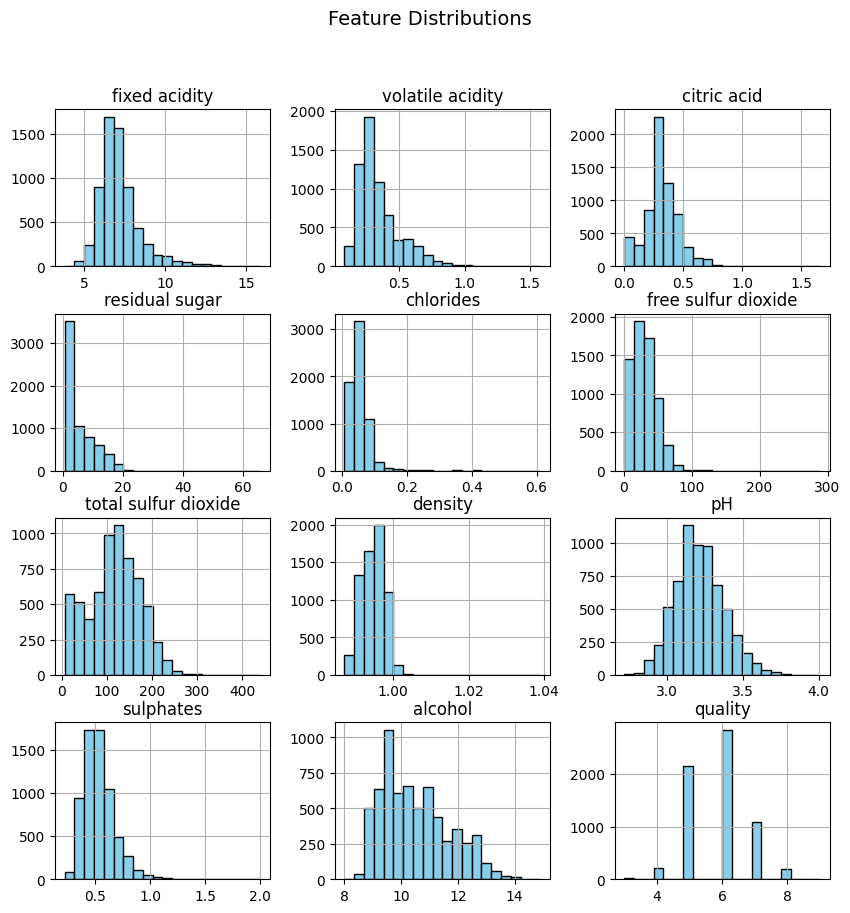

In [ ]:
# --- EDA (Exploratory Data Analysis) ---
plt.figure(figsize=(10, 10))
df.hist(bins=20, figsize=(10, 10), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

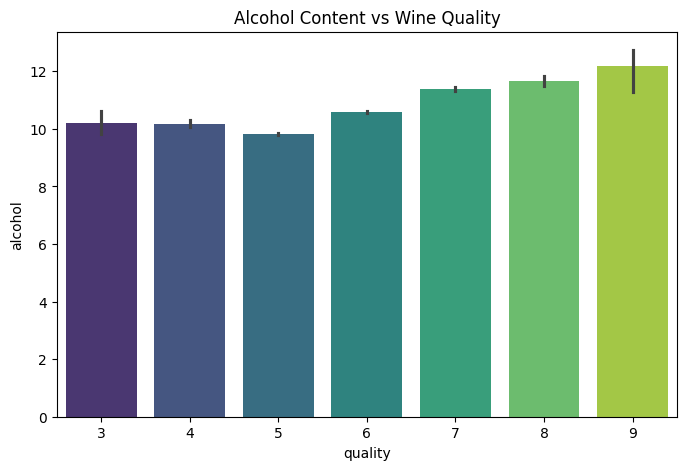

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x="quality", y="alcohol", data=df, palette="viridis")
plt.title("Alcohol Content vs Wine Quality")
plt.show()

In [ ]:
# --- Data Type Correction ---
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

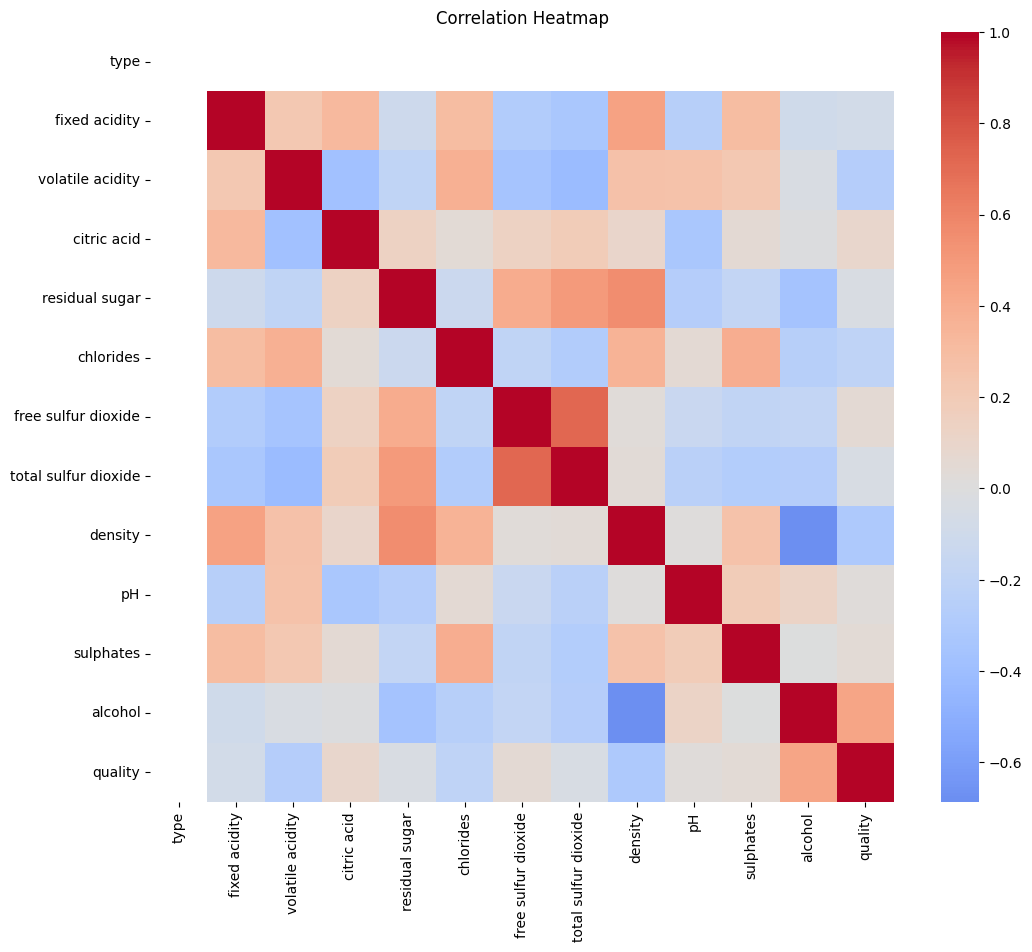

In [ ]:
# --- Correlation Analysis ---
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# --- Feature Engineering ---
df.drop(columns=["total sulfur dioxide"], inplace=True)
df["best_quality"] = (df["quality"] > 5).astype(int)
df.replace({"white": 1, "red": 0}, inplace=True)

In [ ]:
# --- Feature Engineering ---
df["best_quality"] = (df["quality"] > 5).astype(int)
df.replace({"white": 1, "red": 0}, inplace=True)

In [ ]:
# --- Split Data ---
X = df.drop(columns=["quality", "best_quality"])
y = df["best_quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- Imputation & Normalization ---
imputer = SimpleImputer(strategy="mean")
scaler = MinMaxScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# --- Model Training ---
models = {
    "Logistic Regression": LogisticRegression(),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Support Vector Classifier": SVC(kernel="rbf", probability=True)
}

print("\nModel Training and Evaluation:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model.predict(X_train))
    test_auc = roc_auc_score(y_test, model.predict(X_test))
    print(f"{name}\n  ▶ Train ROC-AUC: {train_auc:.4f}\n  ▶ Test ROC-AUC:  {test_auc:.4f}\n")


Model Training and Evaluation:

Logistic Regression
  ▶ Train ROC-AUC: 0.6961
  ▶ Test ROC-AUC:  0.7013

XGBoost Classifier
  ▶ Train ROC-AUC: 0.9753
  ▶ Test ROC-AUC:  0.8251

Support Vector Classifier
  ▶ Train ROC-AUC: 0.7216
  ▶ Test ROC-AUC:  0.7337



In [ ]:
# --- Best Model Evaluation (XGBoost) ---
best_model = models["XGBoost Classifier"]
y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       468
           1       0.88      0.87      0.87       832

    accuracy                           0.84      1300
   macro avg       0.82      0.83      0.82      1300
weighted avg       0.84      0.84      0.84      1300



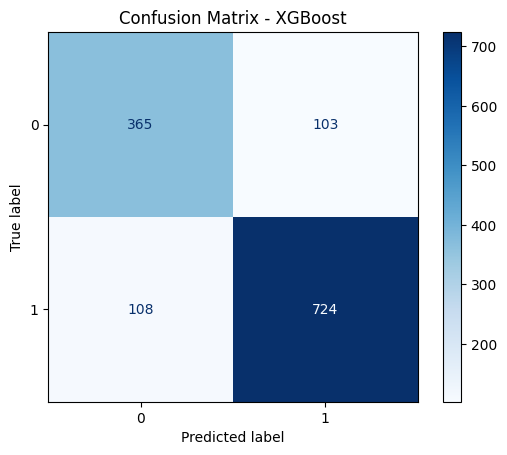

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()